In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # エンコーダー
        self.encoder = nn.Sequential(
            nn.Linear(680, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
        )

        # デコーダー
        self.decoder = nn.Sequential(
            nn.Linear(2, 512),
            nn.ReLU(),
            nn.Linear(512, 680),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = x.chunk(2, dim=1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var


def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


def train(model, data_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data,) in enumerate(data_loader):
        data = data.to("cuda")
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    average_loss = train_loss / len(data_loader.dataset)
    print(f"Average loss: {average_loss:.4f}")

In [3]:
with open('tmp/data.pkl', 'rb') as f:
    data = pickle.load(f)
with open('tmp/data_id_dict.pkl', 'rb') as f:
    data_id_dict = pickle.load(f)
with open('tmp/child_id_dict.pkl', 'rb') as f:
    child_id_dict = pickle.load(f)
with open('tmp/word_dict.pkl', 'rb') as f:
    word_dict = pickle.load(f)
with open('tmp/category_dict.pkl', 'rb') as f:
    category_dict = pickle.load(f)

tensor_data = torch.tensor(data.astype(np.float32))
dataset = TensorDataset(tensor_data)
data_loader = DataLoader(dataset, batch_size=64)

model = VAE().to("cuda")
model.load_state_dict(torch.load("tmp/best_model.pth"))
# model.load_state_dict(torch.load("tmp/model_state_dict.pth"))

<All keys matched successfully>

In [4]:
data

array([[1., 0., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [5]:
def data_to_z(model, data):
    model.eval()
    with torch.no_grad():
        data = torch.tensor(data.astype(np.float32)).cuda()
        zs = model.encoder(data)
        mu, log_var = zs.chunk(2, dim=1)
        z_points = mu.cpu()
        z_points = np.array(z_points)
        return z_points


def z_to_data(model, z):
    model.eval()
    with torch.no_grad():
        z = torch.tensor(z.astype(np.float32)).cuda()
        data = model.decoder(z)
        data = np.array(data.cpu())
        return data


def get_vocabulary(data):
    return np.sum(data, axis=1)

In [6]:
def plot_z(model, zs):
    fig, ax = plt.subplots()
    ax.scatter(zs[:, 0], zs[:, 1])

    # all_0s = np.zeros((1, 680))
    # z0 = data_to_z(model, all_0s)
    # all_1s = np.ones((1, 680))
    # z1 = data_to_z(model, all_1s)
    # ax.scatter(
    #     z0[:, 0], z0[:, 1], c=age_min, cmap=cmap, norm=norm, label="all 0s", marker="x"
    # )
    # ax.scatter(
    #     z1[:, 0], z1[:, 1], c=age_max, cmap=cmap, norm=norm, label="all 1s", marker="x"
    # )
    # ax.legend()
    plt.show()


def plot_data(model, data):
    fig, ax = plt.subplots()
    zs = data_to_z(model, data)
    ax.scatter(zs[:, 0], zs[:, 1], s=0.2)

    all_0s = np.zeros((1, 680))
    z0 = data_to_z(model, all_0s)
    all_1s = np.ones((1, 680))
    z1 = data_to_z(model, all_1s)
    ax.scatter(z0[:, 0], z0[:, 1], color="blue", label="all 0s", marker="x")
    ax.scatter(z1[:, 0], z1[:, 1], color="red", label="all 1s", marker="*")
    ax.legend()
    ax.set_xlabel(r"$z_{1}$")
    ax.set_ylabel(r"$z_{2}$")
    plt.show()

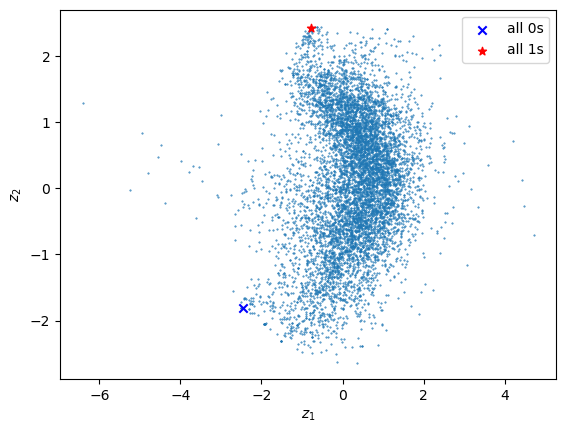

In [7]:
plot_data(model, data)

In [8]:
# plot_data(model, data)

In [9]:
# 潜在空間の格子点
import itertools


def make_lattice_points(
    z1_start: float, z1_end: float, z2_start: float, z2_end: float, spacing: float
) -> np.float32:
    z1 = np.arange(z1_start, z1_end + spacing, spacing)
    z2 = np.arange(z2_start, z2_end + spacing, spacing)

    zs = np.array(list(itertools.product(z1, z2)), dtype=np.float32)
    return zs, (len(z1), len(z2))


def plot_vocabulary(model, z1_start, z1_end, z2_start, z2_end, spacing):
    zs, size = make_lattice_points(z1_start, z1_end, z2_start, z2_end, spacing)
    data = z_to_data(model, zs)
    # vocabulary = get_vocabulary(data).reshape(size)
    vocabulary = get_vocabulary(data).reshape(size[::-1], order="F")
    # vocabulary = np.flipud(vocabulary)
    plt.imshow(vocabulary, extent=[z1_start, z1_end, z2_start, z2_end], cmap="turbo", origin="lower")
    plt.colorbar()
    plt.xlabel(r"$z_{1}$")
    plt.ylabel(r"$z_{2}$")
    plt.show()

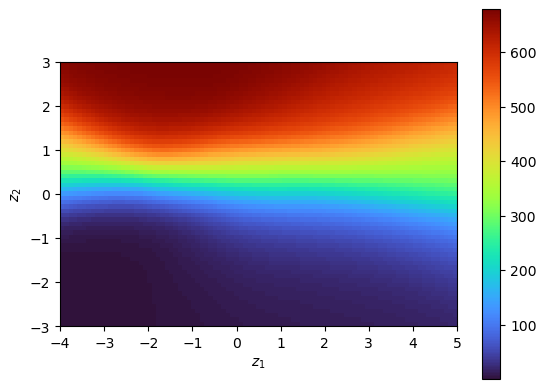

In [10]:
z1_start, z1_end = -4, 5
z2_start, z2_end = -3, 3
spacing = 0.1

zs, size = make_lattice_points(z1_start, z1_end, z2_start, z2_end, spacing)
plot_vocabulary(model, z1_start, z1_end, z2_start, z2_end, spacing)